<a href="https://colab.research.google.com/github/LauJohansson/AnomalyDetection_VariationalAutoencoderLSTM/blob/master/VAE_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational autoencoder
*Authors: Jonas Søbro Christophersen & Lau Johansson*


# Importing and data preparation

## Import

In [0]:
from __future__ import print_function
import argparse

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import normalize 

torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Set seed
torch.manual_seed(0)

#Function to test memory usage
def print_memory(a):
  print("Tensor is using {} MB memory.".format(a.element_size() * a.nelement() * 1e-6 ))

## Flags
This namespace contains all hyperparameters for the model

In [0]:
# Flags for the model
flags = argparse.Namespace(
    print_every=1, #lower value, more often test/train loss print. Based on epoch
    lstm_size = 128,
    latent_size = 1,
    input_size = 2, # 
    learning_rate = 1e-2,
    seq_size = 500,
    n_lay = 1,
    batch_size = 4,
    print_interval = 2,
    epochs = 5,
    number_of_noisy_obs=5,
    lambda_kl=0.001, #tune the prior? fit data vs. fit prior. Prior is zero mean gussian. try to set it to 0
    lambda_max=1,
    lambda_update_rate=0.01,
    num_of_directions=2,
    attention_size=3,
    optimizer_choice='AdamW', #AdamW , #SGD
    mode = "online small data", #"online small/big data"
    number_of_data_files=1000,
    pickle='No' #No
) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Loading data

In [0]:

####### LOAD NEW DATA

if (flags.pickle!='Yes'):
  if flags.mode == "online big data":
    # Load data
    #https://lab.compute.dtu.dk/02460F20-tsad/shared

    import glob
    from scipy.io import loadmat

    from google.colab import drive

    drive.mount('/content/drive')

    # Load files for given cases only
    input_dir = 'drive/My Drive/Advanced Machine Learning/data/Lira/Synth_data_20042020_speed40/'
    #min_index = 7000
    #max_index = 18000
    file_pattern = '{0}*.mat'.format(input_dir)

    # Load data from mat files into python dictionary
    data = {}
    print('Loading data....')
    i=1
    for filename in glob.glob(file_pattern):
        i=i+1
        if(i==flags.number_of_data_files):
          break;
        
        #print('Loading file: {0}'.format(filename))
        defect_type = filename.split('_')[-3] # changed to -3 from -2

        # Get variables
        f = loadmat(filename)
        acc = f['acceleration'][:,:].reshape(1,-1)
        time = f['time'][:,:].reshape(1,-1)
        label = f['type'][:,:].reshape(1,-1)
        severity = f['severity'][:,:].reshape(1,-1)

        # Update dictionary with the data from this file
        data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}
    print('Loading finished.')
    list_of_filenames = list(data.keys())

  ##############################################################################

  if flags.mode == "online small data":
    # Load data
    #https://lab.compute.dtu.dk/02460F20-tsad/shared

    import glob
    from scipy.io import loadmat

    from google.colab import drive

    drive.mount('/content/drive')

    # Load files for given cases only
    input_dir = 'drive/My Drive/Advanced Machine Learning/data/Lira/Synt_data_20052019/'
    min_index = 7000
    max_index = 18000
    file_pattern = '{0}*.mat'.format(input_dir)

    # Load data from mat files into python dictionary
    data = {}
    print('Loading files...')
    for filename in glob.glob(file_pattern):
        #print('Loading file: {0}'.format(filename))
        defect_type = filename.split('_')[-2]

        # Get variables
        f = loadmat(filename)
        acc = f['acceleration'][min_index:max_index,:].reshape(1,-1)
        time = f['time'][min_index:max_index,:].reshape(1,-1)
        label = f['type'][min_index:max_index,:].reshape(1,-1)
        severity = f['severity'][min_index:max_index,:].reshape(1,-1)

        # Update dictionary with the data from this file
        data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}

    list_of_filenames = list(data.keys())
    print('Loading done!')


  ###############################################################################
  if flags.mode == "local":
    import glob
    from scipy.io import loadmat

    # Load files for given cases only
    input_dir = 'D:/DataForProgramming/lira/data/Lira/Synt_data_20052019/'
    min_index = 7000
    max_index = 18000
    file_pattern = '{0}*.mat'.format(input_dir)

    # Load data from mat files into python dictionary
    data = {}
    print('Loading files...')
    for filename in glob.glob(file_pattern):
        #print('Loading file: {0}'.format(filename))
        
        defect_type = filename.split('_')[-2]

        # Get variables
        f = loadmat(filename)
        acc = f['acceleration'][min_index:max_index,:].reshape(1,-1)
        time = f['time'][min_index:max_index,:].reshape(1,-1)
        label = f['type'][min_index:max_index,:].reshape(1,-1)
        severity = f['severity'][min_index:max_index,:].reshape(1,-1)

        # Update dictionary with the data from this file
        data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}
    print('Loading finish')
    list_of_filenames = list(data.keys())

if flags.pickle == "Yes":
  print('Pickle is used')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading files...
Loading done!


### Data generator

In [0]:
if (flags.pickle!='Yes'):
  data_list = []
  # Get all crack data

  print('Generating...')
  for k in range(len(list_of_filenames)):
    if (flags.mode=='online small data'): #When small data online take crack
      if (data[list_of_filenames[k]]['defect'] == 'crack'):
        
        #selected every column and normalizing
        
        col1 = data[list_of_filenames[k]]['acc'][0]
        col2 = data[list_of_filenames[k]]['severity'][0]
        col3 = data[list_of_filenames[k]]['time'][0]  
        col4 = data[list_of_filenames[k]]['true_labels'][0]

        for l in range(flags.number_of_noisy_obs): # Add noisy observations
          noisy_col1 = col1 + np.random.normal(0,np.std(col1) / 5 ,len(col1))
          noisy_col2 = col2 + np.random.normal(0,np.std(col2) / 5 ,len(col2))
          data_list.append(([noisy_col1, noisy_col2, col3, col4]))
          #data_list.append(([normalize([noisy_col1]), normalize([noisy_col2]), col3, col4]))

        data_list.append(([col1, col2, col3, col4])) # add original data
        #data_list.append(([normalize([col1]), normalize([col2]), col3, col4])) # add original data normalized
    else:
        col1 = normalize(data[list_of_filenames[k]]['acc'][0]) 
        col2 = normalize(data[list_of_filenames[k]]['severity'][0]) 
        col3 = data[list_of_filenames[k]]['time'][0] 
        col4 = data[list_of_filenames[k]]['true_labels'][0]

        for l in range(flags.number_of_noisy_obs): # Add noisy observations
          
          noisy_col1 = col1 + np.random.normal(0,np.std(col1) / 5 ,len(col1))
          
          noisy_col2 = col2 + np.random.normal(0,np.std(col2) / 5 ,len(col2))
          data_list.append(([noisy_col1, noisy_col2, col3, col4]))
          #data_list.append(([normalize(noisy_col1.reshape(-1,1)), normalize(noisy_col2.reshape(-1,1)), col3, col4]))

        data_list.append(([col1, col2, col3, col4])) # add original data
        #data_list.append(([normalize(col1.reshape(-1,1)), normalize(col2.reshape(-1,1)), col3, col4])) # add original data normalized
  data_torch = torch.tensor(data_list)
  data_torch = data_torch.permute(2, 0, 1)
  data_torch = data_torch.float()
  data_torch=data_torch.to(device)
  print('Generation done!')

else:
  print('Pickle is used!')

Generating...
Generation done!


## loading pickle instead

In [0]:
if (flags.pickle=='Yes'):
  # LOAD PRELOADED DATA
  print('Loading...')
  list_of_labels = torch.load('/content/drive/My Drive/Advanced Machine Learning/data/list_of_labels.pth')
  data_torch = torch.load('/content/drive/My Drive/Advanced Machine Learning/data/data_torch.pth')
  print('Loading done!')

### Data train/test splitter

Check the dimension of the data:

In [0]:
#data_list has all data
print(data_torch.shape)

torch.Size([11000, 48, 4])


Slicing data so it only has a sequence length of 500 and not long tails:

In [0]:

#fraction=int(data_torch.shape[1]*0.8)
#X_train=data_torch[:,:fraction,:]
#X_test=data_torch[:,fraction+1:,:]

#


if (flags.pickle=='Yes' or flags.mode=='online big data'):
  start_slice=100 # 2000
  end_slice=600   #7000
  nm_p=1 #take every nm_p point

  train_batch_idx=200#40
  test_batch_idx=220 #60 #(when small data)

  X_train=data_torch[start_slice:end_slice:nm_p,:train_batch_idx,:2] #only acceleration and severity
  X_test=data_torch[start_slice:end_slice:nm_p,train_batch_idx:test_batch_idx,:2]

elif(flags.mode=='online small data'):
  start_slice= 2000
  end_slice=7000
  nm_p=10 #take every nm_p point

  train_batch_idx=40
  test_batch_idx=60 #(when small data)

  X_train=data_torch[start_slice:end_slice:nm_p,:train_batch_idx,:2] #only acceleration and severity
  X_test=data_torch[start_slice:end_slice:nm_p,train_batch_idx:test_batch_idx,:2]

else:
  raise Exception('Data not loaded properly')

print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_test: {}'.format(X_test.shape))


#X_train=F.normalize(X_train,dim=0) #normalize
#X_test=F.normalize(X_test,dim=0)


#means = X_train.mean(dim=0, keepdim=True)
#stds = X_train.std(dim=0, keepdim=True)
#normalized_X_Train_data = (X_train - means) / stds
#X_train=normalized_X_Train_data



The shape of X_train: torch.Size([500, 40, 2])
The shape of X_test: torch.Size([500, 8, 2])


In [0]:
from sklearn import preprocessing


In [0]:
#for i in range(X_train.shape[1]):
#  for j in range(X_train.shape[2]):
#    mini=X_train[:,i,j].min()
#    maxi=X_train[:,i,j].max()
#    X_train[:,i,j]=torch.FloatTensor(preprocessing.scale(X_train[:,i,j].cpu().numpy()))

In [0]:
for i in range(X_train.shape[1]):
  for j in range(X_train.shape[2]):
    mini=X_train[:,i,j].min()
    maxi=X_train[:,i,j].max()
    X_train[:,i,j]=2*((X_train[:,i,j]-mini)/(maxi-mini))-1

In [0]:
for i in range(X_test.shape[1]):
  for j in range(X_test.shape[2]):
    mini=X_test[:,i,j].min()
    maxi=X_test[:,i,j].max()
    X_test[:,i,j]=2*((X_test[:,i,j]-mini)/(maxi-mini))-1

In [0]:
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_test: {}'.format(X_test.shape))


The shape of X_train: torch.Size([500, 40, 2])
The shape of X_test: torch.Size([500, 8, 2])


In [0]:
#X_train[2,0,1]

### Plotting data

In [0]:
#batch_norm=nn.BatchNorm1d(4)
#X_train[:,0:flags.batch_size,:]=batch_norm(X_train[:,0:flags.batch_size,:].cpu())

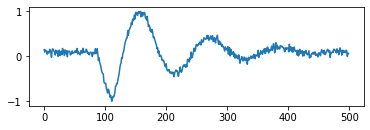

In [0]:
# Plot true data (0 is acceleration)
plt.subplot(2,1,1)
plt.plot((X_train[:,0,:][:,0]).cpu().detach().numpy())
plt.show()

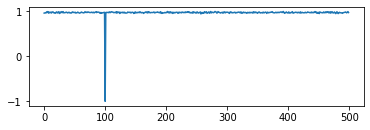

In [0]:
# Plot true data (1 is seveiry)
plt.subplot(2,1,1)
plt.plot((X_train[:,0,:][:,1]).cpu().detach().numpy())
plt.show()

# The Model

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.seq_size = flags.seq_size
        self.lstm_size = flags.lstm_size
        self.latent_size = flags.latent_size
        self.attention_size=flags.attention_size
        self.input_size = flags.input_size
        self.batch_size = flags.batch_size
        self.num_layers = flags.n_lay
        self.directions=flags.num_of_directions
        self.batch_norm=nn.BatchNorm1d(self.input_size)
        self.softmax = nn.Softmax(dim=0)
        self.SoftP=nn.Softplus()

        #Encoder lstm:
        self.encoder1 = nn.LSTM(self.input_size, self.lstm_size, self.num_layers, bidirectional = True)

        #Linear from encoder to variational layer
        self.encoder_mu = nn.Linear(self.lstm_size * self.batch_size * self.directions, self.latent_size * self.batch_size) 
        self.encoder_logvar = nn.Linear(self.lstm_size* self.batch_size * self.directions, self.latent_size * self.batch_size)
        
        #Attention to decoder
        #Mean and variance linear layer for transforming c_det ----->  to c_t
        self.encoder_att_mu = nn.Linear(self.batch_size * self.lstm_size * self.directions , self.batch_size * self.attention_size )
        self.encoder_att_logvar = nn.Linear(self.batch_size * self.lstm_size * self.directions , self.batch_size * self.attention_size )
         
        #Decoder lstm
        self.decoder1 = nn.LSTM(self.latent_size + self.attention_size, self.lstm_size, self.num_layers, bidirectional = True) #*2 because z and c has same dimension

        #Linear from decoder lstm to output
        self.reconstruction_mu = nn.Linear(self.batch_size * self.lstm_size * self.directions, self.batch_size * self.input_size)


    def encode(self, x):
        
        #Pass input to encoder lstm
        output_encoder, (h_n,c_n) = self.encoder1(x)
        
        #Tanh activation on lstm last hidden 
        h1 = torch.tanh(h_n).view(-1,self.lstm_size * self.batch_size * self.directions) 
        

        #Return encoded mu and logvar ( with softplus) ready to variational-layer. Returning output ready to "attention-layer"
        return self.encoder_mu(h1), self.SoftP(self.encoder_logvar(h1)), output_encoder 

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std) #randn_like -> mean 0 and standarddeviation 1. Dimension same as "std"
        return mu + eps*std
        
    def attention(self, out_encoder):
        # Compute score S atrix s11, s12, ... sTT and A scores.
        for batch_idx in range(self.batch_size):
           
            if batch_idx == 0:
                s_tensor = torch.div(torch.matmul(out_encoder[:,batch_idx,:], (out_encoder[:,batch_idx,:]).t()) , np.sqrt(self.lstm_size * self.directions))
                a_tensor = self.softmax(s_tensor)  
                del s_tensor
                c_det = (a_tensor.unsqueeze(1) * out_encoder[:,batch_idx,:].unsqueeze(2)).sum(dim=2)
                
            else:
                s_score = ((torch.mm(out_encoder[:,batch_idx,:], (out_encoder[:,batch_idx,:]).t())) / np.sqrt(self.lstm_size * self.directions))
                a_score = self.softmax(s_score)
                del s_score
                a_tensor = torch.cat((a_tensor, a_score), 1)
                c_det_batch = (a_tensor.unsqueeze(1) * out_encoder[:,batch_idx,:].unsqueeze(2)).sum(dim=2)
                c_det = torch.cat((c_det, c_det_batch), 1)
              
        return c_det.view(-1, self.batch_size, self.lstm_size * self.directions)


    def decode(self, z, c):
       
        #Replicate z to be passed with every c's
        zrep = z.view(-1, self.batch_size, self.latent_size).repeat(self.seq_size, 1, 1)

        #View c so dimension fits to zrep
        c = c.view(-1, self.batch_size, self.attention_size )

         # Concatenate z and c
        zandc = torch.cat((zrep,c), 2)
        
        #Pass z and c to decoder lstm
        output_decoder, state_decoder = self.decoder1(zandc)

        #Returning the the reconstructed data
        return self.reconstruction_mu(torch.tan(output_decoder.view(-1,self.lstm_size * self.batch_size * self.directions))), state_decoder
        


    def forward(self, x):  
        #Encode-layer
        mu, logvar, output_encoder = self.encode(x)

        #"Variational layer"
        z = self.reparameterize(mu, logvar)

        #Attention-layer
        c_det = self.attention(output_encoder)
 
        #Attention to decoder.     Pass each c_det one at a time.
        for t in range(flags.seq_size):
            if (t==0):
              c_0= c_det[t,:,:]
              c_t_mu=self.encoder_att_mu(c_0.view(-1,self.batch_size * self.lstm_size * self.directions))
              c_t_logvar=self.SoftP(self.encoder_att_logvar(c_0.view(-1,self.batch_size * self.lstm_size * self.directions)))
              c_final=self.reparameterize(c_t_mu, c_t_logvar)
              del c_0
              del c_t_mu
              del c_t_logvar
            else:
              c_current= c_det[t,:,:]
              c_t_mu=self.encoder_att_mu(c_current.view(-1,self.batch_size * self.lstm_size * self.directions))
              c_t_logvar=self.SoftP(self.encoder_att_logvar(c_current.view(-1,self.batch_size * self.lstm_size * self.directions)))
              c_final=torch.cat((c_final,self.reparameterize(c_t_mu, c_t_logvar)),0)

        #Decode-layer
        output, state_decoder = self.decode(z, c_final)


        ###--------- Reconstruction-------###
        
        #recon_mu, recon_b =self.reconstrunction(output)

        #for loop:
          #output.append(self.reparametrize(recon_mu,recon_b))
        #output=mean(output)

        #####################################
       
        return output.view(-1,self.batch_size,self.input_size), mu, logvar, output_encoder, state_decoder, c_det,z
    
    
   

## Init model

In [0]:
torch.backends.cudnn.enabled = False
model = VAE().to(device)

## Optimizer

In [0]:
if (flags.optimizer_choice=='AdamW'):
  optimizer = optim.AdamW(model.parameters(), lr = flags.learning_rate)
elif(flags.optimizer_choice=='SGD'):
  optimizer = optim.SGD(model.parameters(), lr = flags.learning_rate)
else: #
  optimizer = optim.Adam(model.parameters(), lr = flags.learning_rate)

## Test model 

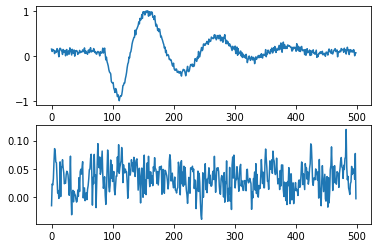

In [0]:
output, _, _, _, _, _,_ = model(X_train[:,0:flags.batch_size,:])
# Compare true data with reconstructed data (0 is acceleration)
plt.subplot(2,1,1)
plt.plot((X_train[:,0,:][:,0]).cpu().detach().numpy())
plt.subplot(2,1,2)
plt.plot((output[:,0,:][:,0]).cpu().detach().numpy())
plt.show()

# Functions




## Loss

In [0]:
#https://github.com/GauravBh1010tt/DL-Seq2Seq/blob/master/variational%20autoencoders%20(VAE%2C%20CVAE)/vae.py
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar,lamb):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, flags.seq_size), reduction='sum')
    CE = F.mse_loss(recon_x, x, reduction='sum')
    #CE = F.cross_entropy(recon_x, x)
    

    # J. Pereira, "Thesis - Unsupervised Anomaly Detection in Time Series Data using Deep Learning" page 90 (equation 12)
    # lambda_KL*-0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = lamb*(-0.5) * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return CE + KLD

## Get batches

In [0]:
# Get batches
def get_batches(iterable, n = flags.batch_size):
    l = iterable.shape[1]   # Number of total samples (48)
    for ndx in range(0, l, n):
        yield iterable[:,ndx:min(ndx + n, l),:]

## Train model

In [0]:
def train(epoch,lambda_kl):
    model.train()
    train_loss = 0
  
    batches = get_batches(X_train)
    for trainbatch in batches:
        trainbatch = trainbatch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, _, _, _,_ = model(trainbatch)
        loss = loss_function(recon_batch, trainbatch, mu, logvar,lambda_kl)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if (epoch % flags.print_every == 0):
      print('Train loss: {:.4f}'.format(train_loss / X_train.shape[1]))
    
    return train_loss / X_train.shape[1]


## Test model

In [0]:
def test(epoch,lambda_kl):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batches = get_batches(X_test)
        for testbatch in batches:
        
          testbatch = testbatch.to(device)
          recon_batch, mu, logvar, _, _, _,_ = model(testbatch)
          loss = loss_function(recon_batch, testbatch, mu, logvar,lambda_kl)
          test_loss += loss.item()
          


            #if i == 0:
             #   n = min(data.size(0), 8)
              #  comparison = torch.cat([data[:n],
               #                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
               # save_image(comparison.cpu(),
               #          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= X_test.shape[1]
    if (epoch % flags.print_every == 0):
      print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

# Main

Epoch 1 / 5
Train loss: 228.2047
Test loss: 110.3081
Epoch 1 running time 0:00:12.807685:
Epoch 2 / 5
Train loss: 139.0887
Test loss: 62.6750
Epoch 2 running time 0:00:12.659688:
Epoch 3 / 5
Train loss: 38.9096
Test loss: 31.3763
Epoch 3 running time 0:00:12.609957:
Epoch 4 / 5
Train loss: 29.4113
Test loss: 23.8985
Epoch 4 running time 0:00:12.559398:
Epoch 5 / 5
Train loss: 13.6325
Test loss: 19.9509
Epoch 5 running time 0:00:12.389786:
Total running time 0:01:03.026879


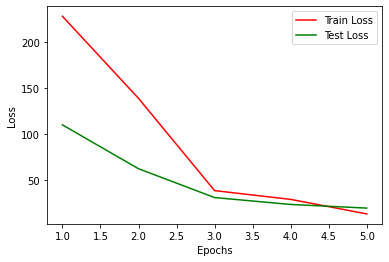

In [0]:
if __name__ == "__main__":
    tic_total= datetime.now()
    epochnumber = []
    all_train_losses = []
    all_test_losses = []
    lambda_update=flags.lambda_kl

    for epoch in range(1, flags.epochs + 1):
        tic = datetime.now()
        epochnumber.append(epoch)
        print("Epoch {} / {}".format(epoch,flags.epochs))
        
        all_train_losses.append(train(epoch,lambda_update))
        all_test_losses.append(test(epoch,lambda_update))
        #with torch.no_grad():
        #    sample = torch.randn(64, 20).to(device)
        #    sample = model.decode(sample).cpu()
        #    save_image(sample.view(64, 1, 28, 28),
         #              'results/sample_' + str(epoch) + '.png')
        
        print("Epoch {} running time {}:".format(epoch,datetime.now() - tic))
        
         #update lambda
        if (lambda_update<flags.lambda_max):
           lambda_update+=flags.lambda_update_rate
    print("Total running time {}".format(datetime.now() - tic_total))
    
    plt.figure(1)                             
    plt.xlabel('Epochs'), plt.ylabel('Loss')   
    plt.plot(epochnumber, all_train_losses, 'r', epochnumber, all_test_losses, 'g')
    plt.legend(['Train Loss', 'Test Loss'])
     

## Testing output

Text(0.5, 0, 'Timestep')

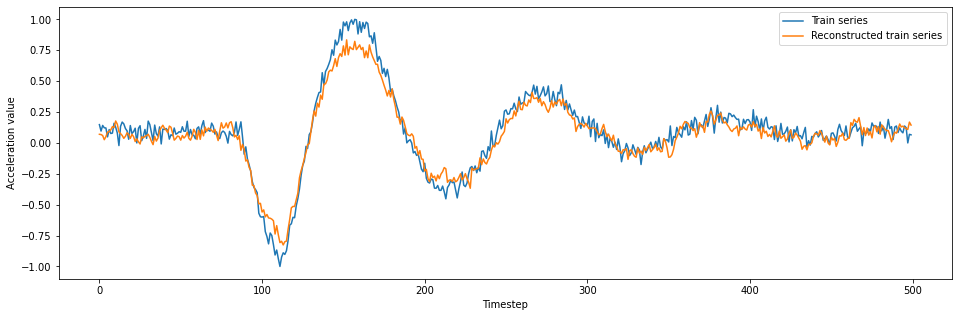

In [0]:
model.eval()
output_good, mu_good, logvar_good, lambda_kl_good, _, c_det_to_pca,z_good = model(X_train[:,0:flags.batch_size,:])
# Compare true data with reconstructed data (0 is acceleration)

plt.figure(figsize=(16,5))
plt.plot((X_train[:,0,:][:,0]).cpu().detach().numpy())
plt.plot((output_good[:,0,:][:,0]).cpu().detach().numpy())
plt.legend(["Train series", "Reconstructed train series"])
plt.ylabel("Acceleration value")
plt.xlabel("Timestep")

In [0]:
loss = loss_function(output[:,0:flags.batch_size,:], X_train[:,0:flags.batch_size,:], mu_good, logvar_good,lambda_kl_good)

In [0]:
loss.mean()

tensor(2048.3965, device='cuda:0', grad_fn=<MeanBackward0>)

### Choose specific defect type and test (only when model has trained on all defect types)

In [0]:
#choose='crack'
#choose='patch'
choose='pothole'

In [0]:
  # Load data
    #https://lab.compute.dtu.dk/02460F20-tsad/shared

import glob
from scipy.io import loadmat

from google.colab import drive

drive.mount('/content/drive')

# Load files for given cases only
input_dir = 'drive/My Drive/Advanced Machine Learning/data/Lira/Synt_data_20052019/'
min_index = 7000
max_index = 18000
file_pattern = '{0}*.mat'.format(input_dir)

# Load data from mat files into python dictionary
data = {}
print('Loading files...')
for filename in glob.glob(file_pattern):
    #print('Loading file: {0}'.format(filename))
    defect_type = filename.split('_')[-2]

    # Get variables
    f = loadmat(filename)
    acc = f['acceleration'][min_index:max_index,:].reshape(1,-1)
    time = f['time'][min_index:max_index,:].reshape(1,-1)
    label = f['type'][min_index:max_index,:].reshape(1,-1)
    severity = f['severity'][min_index:max_index,:].reshape(1,-1)

    # Update dictionary with the data from this file
    data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}

list_of_filenames = list(data.keys())
print('Loading done!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading files...
Loading done!


In [0]:

data_specific_defect_list = []
# Get all crack data


for k in range(len(list_of_filenames)):
  if (data[list_of_filenames[k]]['defect'] == choose):
    
    col1 = normalize(data[list_of_filenames[k]]['acc'][0])
    col2 = normalize(data[list_of_filenames[k]]['severity'][0])
    col3 = data[list_of_filenames[k]]['time'][0] 
    col4 = data[list_of_filenames[k]]['true_labels'][0]

    for l in range(flags.number_of_noisy_obs): # Add noisy observations
      noisy_col1 = col1 + np.random.normal(0,np.std(col1) / 5 ,len(col1))
      noisy_col2 = col2 + np.random.normal(0,np.std(col2) / 5 ,len(col2))
      #data_specific_defect_list.append(([noisy_col1, noisy_col2, col3, col4]))
      data_specific_defect_list.append(([normalize(noisy_col1), normalize(noisy_col2), col3, col4]))

    #data_specific_defect_list.append(([col1, col2, col3, col4])) # add original data
    data_specific_defect_list.append(([normalize(col1), normalize(col2), col3, col4])) # add original data

data_specific_defect_torch = torch.tensor(data_specific_defect_list)
data_specific_defect_torch = data_specific_defect_torch.permute(2, 0, 1)
data_specific_defect_torch = data_specific_defect_torch.float()
data_specific_defect_torch=data_specific_defect_torch.to(device)

ValueError: ignored

In [0]:

#fraction=int(data_torch.shape[1]*0.8)
#X_train=data_torch[:,:fraction,:]
#X_test=data_torch[:,fraction+1:,:]

#



start_slice= 2000
end_slice=7000
nm_p=10 #take every nm_p point

train_batch_idx=40
test_batch_idx=60 #(when small data)

X_train_specific=data_specific_defect_torch[start_slice:end_slice:nm_p,:train_batch_idx,:2] #only acceleration and severity
X_test_specific=data_specific_defect_torch[start_slice:end_slice:nm_p,train_batch_idx:test_batch_idx,:2]



print('The shape of X_train: {}'.format(X_train_specific.shape))
print('The shape of X_test: {}'.format(X_test_specific.shape))


In [0]:
model.eval()
output_specific, _, _, _, _, c_det_to_pca,z_good = model(X_train_specific[:,0:flags.batch_size,:])
# Compare true data with reconstructed data (0 is acceleration)

plt.figure(figsize=(16,5))
plt.plot((X_train_specific[:,0,:][:,0]).cpu().detach().numpy())
plt.plot((output_specific[:,0,:][:,0]).cpu().detach().numpy())
plt.legend(["Train series "+str(choose), "Reconstructed train series "+str(choose)])
plt.ylabel("Acceleration value")
plt.xlabel("Timestep")


### Give a very bad input

**Bad input 1**

In [0]:
'''
Bad input 1:
X_bad=X_train[:,0:flags.batch_size,:].data.clone() + nn.functional.relu((X_train[:,flags.batch_size:flags.batch_size*2,:].data.clone()))*3
'''

**Bad input 2**

In [0]:
'''
#Weird input 2:
X_bad=X_train[:,0:flags.batch_size,:].data.clone() * torch.randn(500,4,2).to(device)
'''

**Bad input 3**

In [0]:
'''
# bad input 3:
X_bad=X_train[:,0:flags.batch_size,:].data.clone()
X_bad[200:400,0,0]=torch.FloatTensor(list(np.ones(200)*10))
X_bad[200:400,1,0]=torch.FloatTensor(list(np.ones(200)*10))
X_bad[200:400,2,0]=torch.FloatTensor(list(np.ones(200)*10))
X_bad[200:400,3,0]=torch.FloatTensor(list(np.ones(200)*10))
'''


**Bad input 4**

In [0]:
'''
# Bad input 4:
bad=[]
x1=range(50,100)
for i in range(len(x1)): 
  bad.append( np.cos(x1[i]/10)) #change here

x2=range(100,150)
for i in range(len(x2)):
  bad.append(-10) #change here

x3=range(150,200)
for i in range(len(x3)): 
  bad.append( np.cos(x3[i]/10)) #change here

X_bad=X_train[:,0:flags.batch_size,:].data.clone()
X_bad[50:200,0,0]=torch.FloatTensor(bad)
X_bad[50:200,1,0]=torch.FloatTensor(bad)
X_bad[50:200,2,0]=torch.FloatTensor(bad)
X_bad[50:200,3,0]=torch.FloatTensor(bad)


**Bad input 5**

In [0]:
'''
#Weird input 5:
X_bad=X_train[:,0:flags.batch_size,:].data.clone() 
X_bad[140:150,0,0]=torch.FloatTensor(list(np.ones(10)*5))
X_bad[160:170,0,0]=torch.FloatTensor(list(np.ones(10)*5))



**Bad input 6**

In [0]:
'''
#weird 6
X_bad=X_train[:,0:flags.batch_size,:].data.clone()
bad=[]
x1=range(0,80)
for i in range(len(x1)): 
  bad.append( np.cos(x1[i])) #change here
X_bad[120:200,0,0]=torch.FloatTensor(bad)


**Bad input 7**

In [0]:

#Bad 7
X_bad=X_train[:,0:flags.batch_size,:].data.clone()
bad=[]
x1=range(0,80)
for i in range(len(x1)): 
  bad.append( 5*np.cos(x1[i]/5)) #change here
X_bad[120:200,0,0]=torch.FloatTensor(bad)


**Bad input 8**

In [0]:

#weird 8
X_bad=X_train[:,0:flags.batch_size,:].data.clone()
X_bad[200:300,0,0]=X_bad[200:300,0,0]*(-1)


In [0]:
model.eval()
output_bad, mu_bad, logvar_bad, lambda_kl_bad, _, c_det_bad,z_bad = model(X_bad[:,0:flags.batch_size,:])

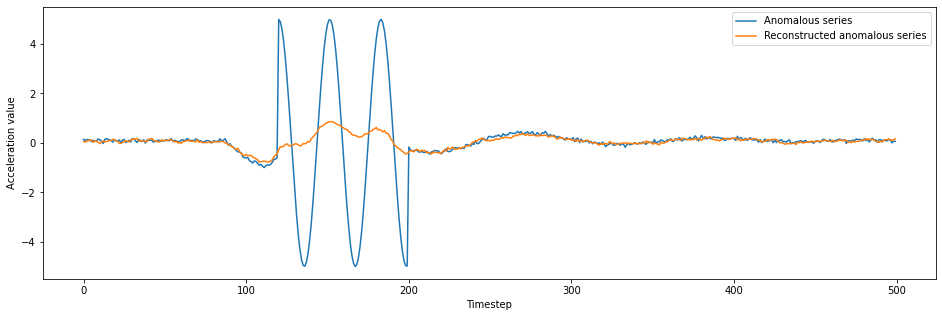

In [0]:
plt.figure(figsize=(16,5))
plt.plot((X_bad[:,0,:][:,0]).cpu().detach().numpy())
plt.plot((output_bad[:,0,:][:,0]).cpu().detach().numpy())
plt.legend(["Anomalous series", "Reconstructed anomalous series"])
plt.ylabel("Acceleration value")
plt.xlabel("Timestep")

#plt.fill_between(range(0,500), (X_weird[:,0,:][:,0]).cpu().detach().numpy(), (output[:,0,:][:,0]).cpu().detach().numpy(), (X_weird[:,0,:][:,0]).cpu().detach().numpy() < (output[:,0,:][:,0]).cpu().detach().numpy(),
#                 color='grey', alpha=0.3)
#plt.fill_between(range(0,500), (X_weird[:,0,:][:,0]).cpu().detach().numpy(), (output[:,0,:][:,0]).cpu().detach().numpy(), (X_weird[:,0,:][:,0]).cpu().detach().numpy() > (output[:,0,:][:,0]).cpu().detach().numpy(),
#                 color='grey', alpha=0.3)

plt.show()


In [0]:
loss = loss_function(output[:,0:flags.batch_size,:], X_bad[:,0:flags.batch_size,:], mu_bad, logvar_bad,lambda_kl_bad)

In [0]:
loss.mean()

# PCA

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

##Good data

In [0]:

from sklearn.decomposition import PCA

In [0]:
X=c_det_to_pca.cpu().detach().numpy()
nsamples, nx, ny = X.shape
d2_train_dataset = X.reshape((nsamples,nx*ny))


In [0]:

X=d2_train_dataset

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X)

plt.scatter(projected[:, 0], projected[:, 1],
             edgecolor='none', alpha=0.5)#,
            #cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## Bad data


In [0]:
#c_det_bad.shape

In [0]:
X3=c_det_bad.cpu().detach().numpy()
nsamples, nx, ny = X3.shape
d2_train_dataset = X3.reshape((nsamples,nx*ny))


In [0]:

X3=d2_train_dataset

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X3)

plt.scatter(projected[:, 0], projected[:, 1],
             edgecolor='none', alpha=0.5),
            #cmap=plt.cm.get_cmap('Accent', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# PCA (More)

In [0]:
import matplotlib

In [0]:
# Initialize a tensor to contain z's with first batch
output, mu, _, _, _, c_final, z_vec = model(X_train[:,0:flags.batch_size,:])
all_zs = z_vec.view(-1,flags.batch_size)
all_mus = mu.view(-1,flags.batch_size)
all_cfinal = c_final

# Iterate over remaining training data batches and grab z-values
nrofbatches = X_train.shape[1] 
for batchnr in range(flags.batch_size, nrofbatches, flags.batch_size):
  output, mu, _, _, _, c_final, z_vec = model(X_train[:,batchnr:batchnr+flags.batch_size,:])
  all_zs = torch.cat((z_vec.view(-1,flags.batch_size), all_zs), 1)
  all_mus = torch.cat((mu.view(-1,flags.batch_size), all_mus), 1)
  all_cfinal = torch.cat((all_cfinal, c_final), 1)

classes = list(np.unique(list_of_labels[0:X_train.shape[1]]))

mydict={}
i = 0
for item in classes:
    if(i>0 and item in mydict):
        continue
    else:    
      i = i+1
      mydict[item] = i
intclasses=[]
for item in list_of_labels:
    intclasses.append(mydict[item])


if flags.latent_size == 2:
  xz = all_zs[0,:].cpu().detach().numpy()
  yz = all_zs[1,:].cpu().detach().numpy()
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xz, yz, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Scatter plot of latent space representation of defects")
  plt.xlabel("Latent space (z) value")
  plt.show()

  xmu = all_mus[0,:].cpu().detach().numpy()
  ymu = all_mus[1,:].cpu().detach().numpy()
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xmu, ymu, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Scatter plot of latent space mu's representation of defects")
  plt.xlabel("Latent space mu value")
  plt.show()

if flags.latent_size == 1:
  xz = all_zs[0,:].cpu().detach().numpy()
  yz = torch.rand(len(xz))
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xz, yz, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Jitter plot of latent space representation of defects")
  plt.xlabel("Latent space (z) value")
  plt.ylim(-4,4)
  plt.show()

  xmu = all_mus[0,:].cpu().detach().numpy()
  ymu = torch.rand(len(xmu))
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xmu, ymu, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Jitter plot of latent space representation of defects")
  plt.xlabel("Latent space (z) value")
  plt.ylim(-4,4)
  plt.show()



if flags.latent_size > 2:
  from sklearn.decomposition import PCA
  Xz = all_zs.cpu().detach().numpy()
  Xzt = Xz.T 
  pcaz = PCA(2)  # project from latent_size to 2 dimensions
  projectedz = pcaz.fit_transform(Xzt)
  xz = projectedz[:, 0]
  yz = projectedz[:, 1]
  colors = ['red','green','blue']
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xz, yz, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("PCA plot of latent space representation of defects")
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')

  Xmu = all_mus.cpu().detach().numpy()
  Xmu = Xmu.T 
  pcamu = PCA(2)  # project from latent_size to 2 dimensions
  projectedmu = pcamu.fit_transform(Xmu)
  xmu = projectedmu[:, 0]
  ymu = projectedmu[:, 1]
  colors = ['red','green','blue']
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xmu, ymu, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("PCA plot of latent space mu values of defects")
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')


# Make PCA of c_final
from sklearn import preprocessing

Xcfinal = all_cfinal.view(1,batchnr+flags.batch_size,-1).squeeze().cpu().detach().numpy()
Xcfinal = preprocessing.scale(Xcfinal)
pcacfinal = PCA(2)
projectedcfinal = pcacfinal.fit_transform(Xcfinal)
xcfinal = projectedcfinal[:, 0]
ycfinal = projectedcfinal[:, 1]
colors = ['red','green','blue']
fig = plt.figure(figsize=(8,8))
scatter = plt.scatter(xcfinal, ycfinal, c=intclasses[0:X_train.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("PCA plot of attentions c_final")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()